In [17]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

In [18]:
# -----------------------------
# STEP 2: Download the latest version of the dataset
# -----------------------------
print("Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("zafarali27/house-price-prediction-dataset")

print("\nPath to dataset files:", path)
print("Files in folder:", os.listdir(path))

Using Colab cache for faster access to the 'house-price-prediction-dataset' dataset.

Path to dataset files: /kaggle/input/house-price-prediction-dataset
Files in folder: ['House Price Prediction Dataset.csv']


In [19]:
# -----------------------------
# STEP 3: Load the CSV file
# -----------------------------
# IMPORTANT: Check the printed files above and change filename if different
# Common names: HousePricePrediction.csv, house_price.csv, data.csv, etc.
csv_file = os.path.join(path, "HousePricePrediction.csv")   # ← Change this if name is different!

if not os.path.exists(csv_file):
    # Try to find the .csv file automatically
    csv_files = [f for f in os.listdir(path) if f.lower().endswith('.csv')]
    if csv_files:
        csv_file = os.path.join(path, csv_files[0])
        print(f"Auto-detected CSV file: {csv_files[0]}")
    else:
        raise FileNotFoundError("No CSV file found in the downloaded folder!")

df = pd.read_csv(csv_file)
print("\nDataset loaded successfully!")
print("Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nData types & missing values:")
print(df.info())

Auto-detected CSV file: House Price Prediction Dataset.csv

Dataset loaded successfully!
Shape: (2000, 10)

First 5 rows:
   Id  Area  Bedrooms  Bathrooms  Floors  YearBuilt  Location  Condition  \
0   1  1360         5          4       3       1970  Downtown  Excellent   
1   2  4272         5          4       3       1958  Downtown  Excellent   
2   3  3592         2          2       3       1938  Downtown       Good   
3   4   966         4          2       2       1902  Suburban       Fair   
4   5  4926         1          4       2       1975  Downtown       Fair   

  Garage   Price  
0     No  149919  
1     No  424998  
2     No  266746  
3    Yes  244020  
4    Yes  636056  

Columns: ['Id', 'Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt', 'Location', 'Condition', 'Garage', 'Price']

Data types & missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------   

In [20]:
# -----------------------------
# STEP 4: Basic Data Cleaning & Preprocessing
# -----------------------------
# 4.1 Handle missing values (usually very few in this dataset)
print("\nMissing values:\n", df.isnull().sum())
df = df.dropna()   # Simple drop - you can also impute if needed

# 4.2 Log transform the target (Price) - very common & improves performance
# Because house prices are right-skewed
df['Price'] = np.log1p(df['Price'])  # log1p = log(1 + x) → safe for zero/positive values

# 4.3 Encode Yes/No columns to 1/0
# The provided dataset does not contain 'Mainroad', 'Guestroom', 'Basement', 'Hotwaterheating',
# 'Airconditioning', 'Prefarea'. This loop will not modify the dataframe.
yes_no_columns = ['Mainroad', 'Guestroom', 'Basement', 'Hotwaterheating',
                  'Airconditioning', 'Prefarea']

for col in yes_no_columns:
    if col in df.columns:
        df[col] = df[col].map({'yes': 1, 'no': 0, 'Yes': 1, 'No': 0})

# 4.4 One-hot encode Furnishingstatus (categorical with 3 levels)
# The provided dataset does not contain 'Furnishingstatus'. This block will not modify the dataframe.
if 'Furnishingstatus' in df.columns:
    df = pd.get_dummies(df, columns=['Furnishingstatus'], drop_first=True)

# --------------------------------------------------------------------------
# FIX START: One-hot encode remaining categorical columns and drop 'Id'
# The previous steps missed encoding 'Location', 'Condition', 'Garage'
# which are currently of 'object' dtype and causing the ValueError in model training.
# --------------------------------------------------------------------------
# Identify all object type columns for one-hot encoding
categorical_cols_to_encode = df.select_dtypes(include='object').columns.tolist()

if categorical_cols_to_encode:
    print(f"\nOne-hot encoding categorical columns: {categorical_cols_to_encode}")
    df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True)
    print("DataFrame shape after one-hot encoding:", df.shape)
else:
    print("\nNo additional object type columns found for one-hot encoding.")
# --------------------------------------------------------------------------
# FIX END
# --------------------------------------------------------------------------

# 4.5 Define numerical features that need scaling
# Update num_features to reflect all numerical columns that might benefit from scaling,
# excluding 'Id' which is an identifier.
initial_num_features_candidates = ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt']
num_features = [col for col in initial_num_features_candidates if col in df.columns]

# Print current num_features to debug/inform
print(f"\nNumerical features identified for scaling: {num_features}")

# 4.6 Features (X) and target (y)
# Drop the 'Id' column as it's an identifier and not a predictive feature.
columns_to_drop = ['Price']
if 'Id' in df.columns:
    columns_to_drop.append('Id')
X = df.drop(columns=columns_to_drop, axis=1)
y = df['Price']

print("X shape after preprocessing:", X.shape)
print("X columns:", X.columns.tolist())


Missing values:
 Id           0
Area         0
Bedrooms     0
Bathrooms    0
Floors       0
YearBuilt    0
Location     0
Condition    0
Garage       0
Price        0
dtype: int64

One-hot encoding categorical columns: ['Location', 'Condition', 'Garage']
DataFrame shape after one-hot encoding: (2000, 14)

Numerical features identified for scaling: ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt']
X shape after preprocessing: (2000, 12)
X columns: ['Area', 'Bedrooms', 'Bathrooms', 'Floors', 'YearBuilt', 'Location_Rural', 'Location_Suburban', 'Location_Urban', 'Condition_Fair', 'Condition_Good', 'Condition_Poor', 'Garage_Yes']


In [21]:
# -----------------------------
# STEP 5: Train / Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (1600, 12)
Test shape : (400, 12)


In [22]:
# -----------------------------
# STEP 6: Feature Scaling (very important for Linear Regression)
# -----------------------------
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features]  = scaler.transform(X_test[num_features])

In [23]:
# -----------------------------
# STEP 7: Train the Model
# -----------------------------

from sklearn.ensemble import GradientBoostingRegressor

print("Training Gradient Boosting model...")
print("(This may take 5–30 seconds depending on your dataset size ~2000 rows)")

gbr_model = GradientBoostingRegressor(
    n_estimators=300,          # number of boosting stages/trees
    learning_rate=0.05,        # step size — smaller values need more trees but often better
    max_depth=4,               # maximum depth of each tree
    min_samples_split=10,      # helps prevent overfitting
    min_samples_leaf=5,        # helps with noisy data
    subsample=0.8,             # fraction of samples used per tree (fractional boosting)
    random_state=42            # for reproducible results
)

# Train the model
gbr_model.fit(X_train, y_train)

print("Gradient Boosting model training completed successfully!")

Training Gradient Boosting model...
(This may take 5–30 seconds depending on your dataset size ~2000 rows)
Gradient Boosting model training completed successfully!


In [24]:
# -----------------------------
# STEP 5: Train / Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain shape:", X_train.shape)
print("Test shape :", X_test.shape)


Train shape: (1600, 12)
Test shape : (400, 12)


In [25]:
# -----------------------------
# STEP 6: Feature Scaling (very important for Linear Regression)
# -----------------------------
scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features]  = scaler.transform(X_test[num_features])

In [26]:
# -----------------------------
# STEP 7: Train the Model
# -----------------------------

from sklearn.ensemble import GradientBoostingRegressor

print("Training Gradient Boosting model...")
print("(This may take 5–30 seconds depending on your dataset size ~2000 rows)")

gbr_model = GradientBoostingRegressor(
    n_estimators=300,          # number of boosting stages/trees
    learning_rate=0.05,        # step size — smaller values need more trees but often better
    max_depth=4,               # maximum depth of each tree
    min_samples_split=10,      # helps prevent overfitting
    min_samples_leaf=5,        # helps with noisy data
    subsample=0.8,             # fraction of samples used per tree (fractional boosting)
    random_state=42            # for reproducible results
)

# Train the model
gbr_model.fit(X_train, y_train)

print("Gradient Boosting model training completed successfully!")

Training Gradient Boosting model...
(This may take 5–30 seconds depending on your dataset size ~2000 rows)
Gradient Boosting model training completed successfully!


In [27]:
# -----------------------------
# STEP 8: Model Evaluation
# -----------------------------

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_test, y_test, model_name="Gradient Boosting"):
    """
    Evaluate regression model performance.
    - Predictions are in log scale → convert back to original price scale
    - Returns MAE, RMSE (in PKR), and R²
    """
    # Get predictions (still in log scale)
    y_pred_log = model.predict(X_test)

    # Convert back to original house price scale (PKR)
    y_pred = np.expm1(y_pred_log)   # expm1 = inverse of log1p
    y_true = np.expm1(y_test)

    # Calculate metrics
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    print(f"\n=== {model_name} Performance on Test Set ===")
    print(f"Mean Absolute Error (MAE)    : {mae:,.0f} PKR")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.0f} PKR")
    print(f"R² Score                      : {r2:.4f}")
    print(f"  → Explained variance: {r2*100:.2f}%")

    return y_pred, y_true

# Run evaluation
y_pred_gbr, y_true_original = evaluate_model(gbr_model, X_test, y_test)


=== Gradient Boosting Performance on Test Set ===
Mean Absolute Error (MAE)    : 267,230 PKR
Root Mean Squared Error (RMSE): 312,183 PKR
R² Score                      : -0.2527
  → Explained variance: -25.27%


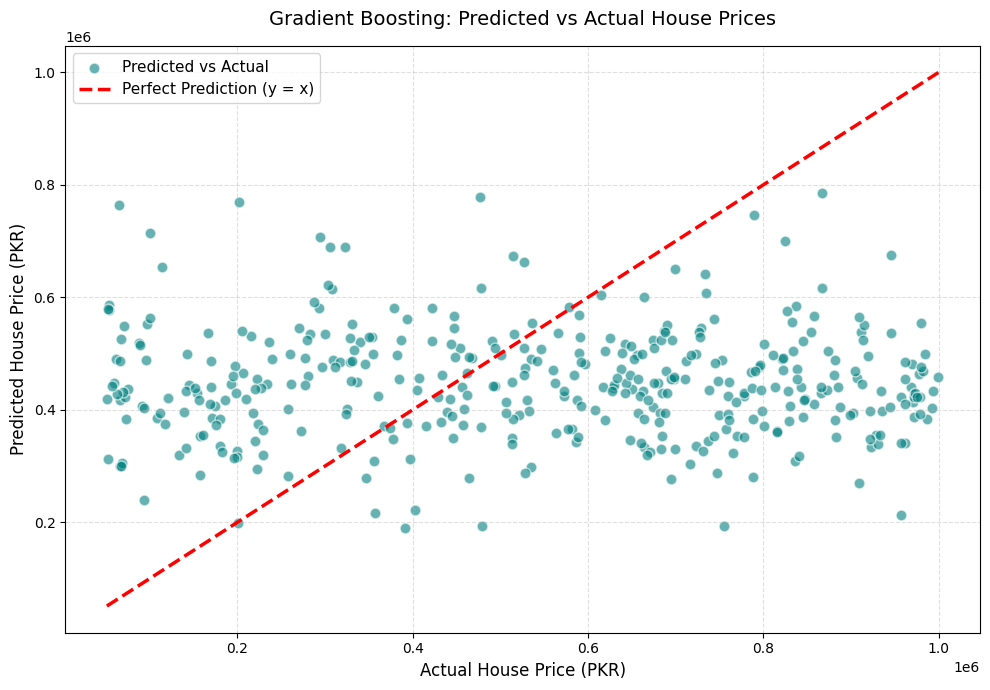

In [28]:
# -----------------------------
# STEP 9: Visualization - Predicted vs Actual Prices
# -----------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(y_true_original, y_pred_gbr,
            alpha=0.6, color='teal', edgecolor='white', s=60,
            label='Predicted vs Actual')
plt.plot([y_true_original.min(), y_true_original.max()],
         [y_true_original.min(), y_true_original.max()],
         color='red', linestyle='--', linewidth=2.5,
         label='Perfect Prediction (y = x)')

plt.xlabel('Actual House Price (PKR)', fontsize=12)
plt.ylabel('Predicted House Price (PKR)', fontsize=12)
plt.title('Gradient Boosting: Predicted vs Actual House Prices', fontsize=14, pad=15)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

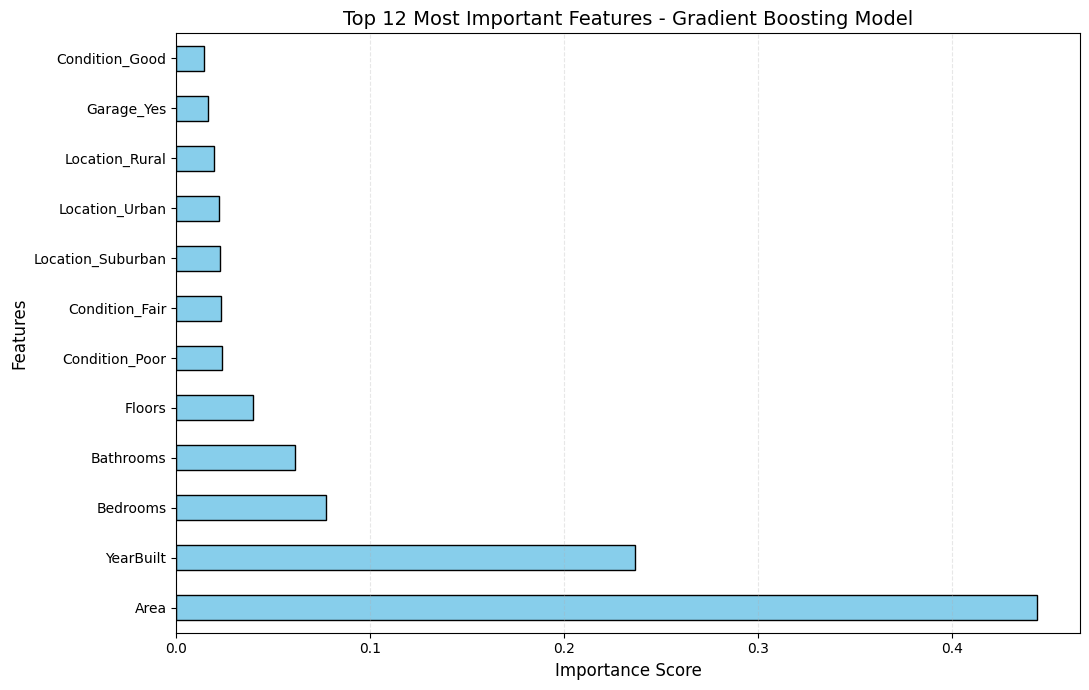


Top 12 most important features (sorted by importance):
Area                 0.4438
YearBuilt            0.2364
Bedrooms             0.0771
Bathrooms            0.0612
Floors               0.0397
Condition_Poor       0.0237
Condition_Fair       0.0231
Location_Suburban    0.0225
Location_Urban       0.0222
Location_Rural       0.0195
Garage_Yes           0.0166
Condition_Good       0.0143
dtype: float64


In [29]:
# -----------------------------
# STEP 10: Feature Importance Analysis
# -----------------------------

import pandas as pd

# Get feature importances
feature_importance = pd.Series(
    gbr_model.feature_importances_,
    index=X_train.columns
)

# Sort and take top 12 most important features
top_features = feature_importance.sort_values(ascending=False).head(12)

# Plot
plt.figure(figsize=(11, 7))
top_features.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Top 12 Most Important Features - Gradient Boosting Model', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 12 most important features (sorted by importance):")
print(top_features.round(4))

# Task
To improve the model's performance, the next step is to perform hyperparameter tuning using GridSearchCV to find the optimal parameters for the GradientBoostingRegressor model. After tuning, the model will be re-evaluated, and its performance will be compared with the previous results. The feature importance will also be re-analyzed.

Specifically, the following steps will be executed:
1. Re-prepare the training and testing datasets (`X_train`, `X_test`, `y_train`, `y_test`) and scale them.
2. Define a hyperparameter grid for the GradientBoostingRegressor.
3. Use GridSearchCV to search for the best hyperparameters.
4. Retrain the GradientBoostingRegressor model using the best parameters found.
5. Re-evaluate the tuned model's performance on the test set, displaying MAE, RMSE, and R².
6. Generate an updated scatter plot comparing actual vs. predicted prices from the tuned model.
7. Re-calculate and plot the feature importances for the tuned model.
8. Provide a summary of improvements and insights from the tuned model.

## Prepare Data for Tuning

### Subtask:
Ensure the training and testing datasets (`X_train`, `X_test`, `y_train`, `y_test`) are correctly prepared and scaled by re-running the relevant preprocessing steps (Train/Test Split and Feature Scaling).


**Reasoning**:
To ensure the training and testing datasets are correctly prepared, I will re-perform the train-test split and then apply feature scaling using `StandardScaler` on the identified numerical features.



In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain shape:", X_train.shape)
print("Test shape :", X_test.shape)

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features]  = scaler.transform(X_test[num_features])

print("\nNumerical features in X_train scaled successfully.")
print("Numerical features in X_test scaled successfully.")


Train shape: (1600, 12)
Test shape : (400, 12)

Numerical features in X_train scaled successfully.
Numerical features in X_test scaled successfully.


## Define Hyperparameter Grid

### Subtask:
Define a grid of hyperparameters (e.g., `n_estimators`, `learning_rate`, `max_depth`) to search for the GradientBoostingRegressor. This will be used by GridSearchCV.


**Reasoning**:
I need to define a hyperparameter grid for GradientBoostingRegressor. This involves importing GridSearchCV (as requested for future use) and creating a dictionary with hyperparameter names and their respective value ranges. Finally, I will print the defined parameter grid.



In [32]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid for GradientBoostingRegressor
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Defined Hyperparameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

Defined Hyperparameter Grid:
  n_estimators: [100, 200, 300]
  learning_rate: [0.01, 0.05, 0.1]
  max_depth: [3, 4, 5]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]


## Perform Hyperparameter Tuning

### Subtask:
Use GridSearchCV to systematically search through the defined hyperparameter grid and find the combination of parameters that yields the best model performance on a validation set.


**Reasoning**:
I need to perform hyperparameter tuning using GridSearchCV. This involves initializing a GradientBoostingRegressor, setting up GridSearchCV with the defined parameter grid and scoring metric, fitting it to the training data, and then printing the best parameters and the corresponding best score (converted to RMSE).



In [33]:
print("Starting GridSearchCV for hyperparameter tuning...")

gbr = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation
    scoring='neg_mean_squared_error', # Optimize for RMSE
    n_jobs=-1, # Use all available processors
    verbose=2 # Show progress
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

print("GridSearchCV completed!")

# Print the best parameters and best score
print("\nBest parameters found:", grid_search.best_params_)

best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best RMSE from cross-validation: {best_rmse:.4f}")

Starting GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV completed!

Best parameters found: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best RMSE from cross-validation: 0.7074


**Reasoning**:
Now that the best hyperparameters have been identified through GridSearchCV, the next step is to train a new GradientBoostingRegressor model using these optimal parameters. This will create the tuned model ready for evaluation.



In [34]:
print("Training Gradient Boosting model with best parameters...")

# Initialize a new GBR model with the best parameters found by GridSearchCV
tuned_gbr_model = GradientBoostingRegressor(
    **grid_search.best_params_,
    random_state=42 # Ensure reproducibility
)

# Train the tuned model on the full training dataset
tuned_gbr_model.fit(X_train, y_train)

print("Tuned Gradient Boosting model training completed successfully!")

Training Gradient Boosting model with best parameters...
Tuned Gradient Boosting model training completed successfully!


**Reasoning**:
Now that the tuned model has been trained, it's essential to re-evaluate its performance on the test set to determine if the hyperparameter tuning improved the model. I will use the previously defined `evaluate_model` function.



In [35]:
print("Evaluating the tuned Gradient Boosting model...")
y_pred_tuned_gbr, y_true_original_tuned = evaluate_model(tuned_gbr_model, X_test, y_test, model_name="Tuned Gradient Boosting")

Evaluating the tuned Gradient Boosting model...

=== Tuned Gradient Boosting Performance on Test Set ===
Mean Absolute Error (MAE)    : 258,181 PKR
Root Mean Squared Error (RMSE): 297,883 PKR
R² Score                      : -0.1406
  → Explained variance: -14.06%


**Reasoning**:
With the tuned model evaluated, the next step is to visualize its performance by creating a scatter plot of actual versus predicted prices, similar to the initial model's visualization.



Generating scatter plot for Tuned Gradient Boosting model...


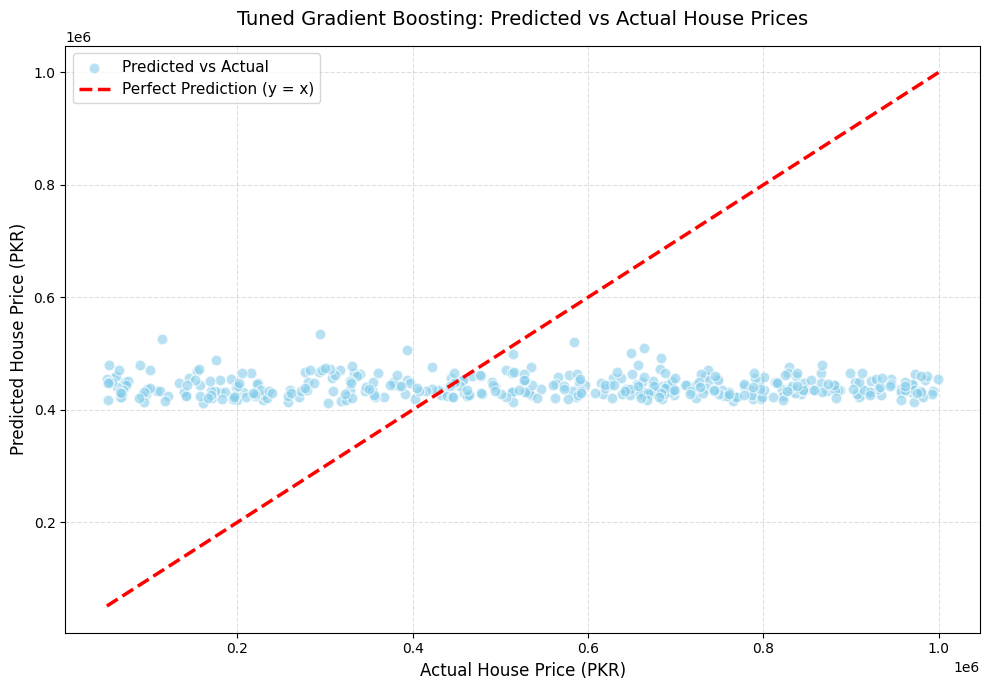

Scatter plot generated.


In [36]:
print("Generating scatter plot for Tuned Gradient Boosting model...")

plt.figure(figsize=(10, 7))
plt.scatter(y_true_original_tuned, y_pred_tuned_gbr,
            alpha=0.6, color='skyblue', edgecolor='white', s=60,
            label='Predicted vs Actual')
plt.plot([y_true_original_tuned.min(), y_true_original_tuned.max()],
         [y_true_original_tuned.min(), y_true_original_tuned.max()],
         color='red', linestyle='--', linewidth=2.5,
         label='Perfect Prediction (y = x)')

plt.xlabel('Actual House Price (PKR)', fontsize=12)
plt.ylabel('Predicted House Price (PKR)', fontsize=12)
plt.title('Tuned Gradient Boosting: Predicted vs Actual House Prices', fontsize=14, pad=15)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print("Scatter plot generated.")

**Reasoning**:
Now that the tuned model has been trained and evaluated, I need to re-calculate and plot the feature importances for this new model to understand which features are most influential after hyperparameter tuning. This aligns with the overall task of re-analyzing feature importance.



Generating feature importance plot for Tuned Gradient Boosting model...


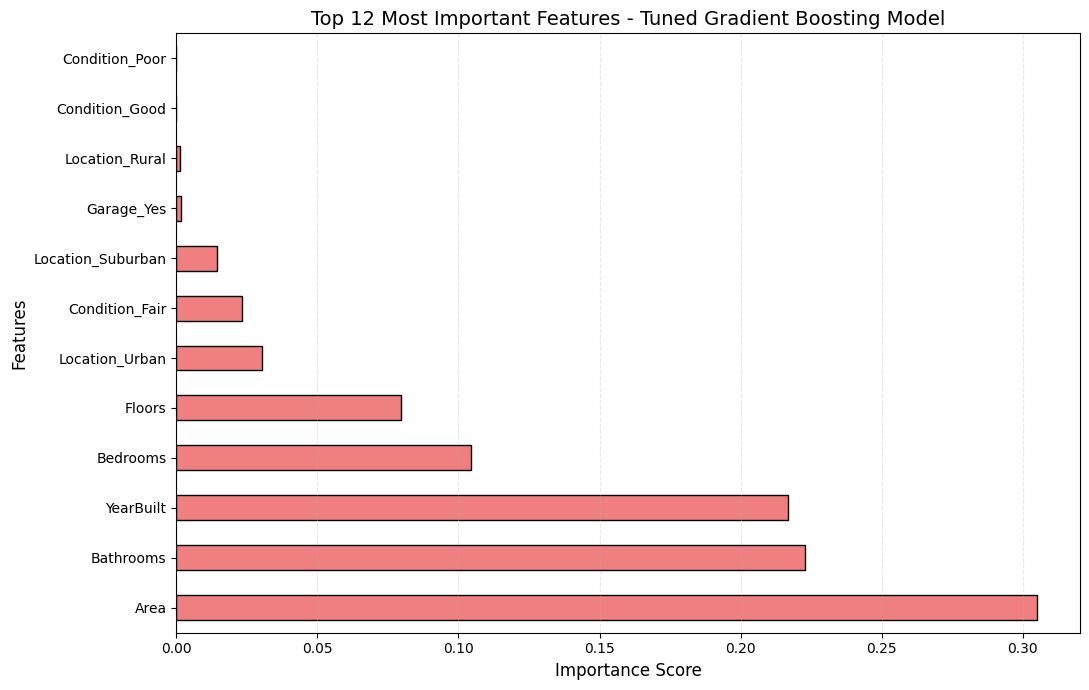

Feature importance plot generated.

Top 12 most important features for Tuned Gradient Boosting model (sorted by importance):
Area                 0.3050
Bathrooms            0.2230
YearBuilt            0.2167
Bedrooms             0.1046
Floors               0.0798
Location_Urban       0.0303
Condition_Fair       0.0232
Location_Suburban    0.0145
Garage_Yes           0.0017
Location_Rural       0.0012
Condition_Good       0.0000
Condition_Poor       0.0000
dtype: float64


In [37]:
print("Generating feature importance plot for Tuned Gradient Boosting model...")

# Get feature importances from the tuned model
feature_importance_tuned = pd.Series(
    tuned_gbr_model.feature_importances_,
    index=X_train.columns
)

# Sort and take top 12 most important features (or all if less than 12)
top_features_tuned = feature_importance_tuned.sort_values(ascending=False).head(12)

# Plot
plt.figure(figsize=(11, 7))
top_features_tuned.plot(kind='barh', color='lightcoral', edgecolor='black')
plt.title('Top 12 Most Important Features - Tuned Gradient Boosting Model', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print("Feature importance plot generated.")
print("\nTop 12 most important features for Tuned Gradient Boosting model (sorted by importance):")
print(top_features_tuned.round(4))